# Penalty Kick Taker Correlation Analysis - Vincent Lawson

### Sources: Penalty Kick Data (DOI: e0315017 Vollmer, Schoch, Brandes), European Soccer Database (Kaggle)

#### Date: 7/14/25

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import kaggle
import kagglehub
import shutil
import os
import sqlite3
import re

## Loading Datasets

In [4]:
path = kagglehub.dataset_download("hugomathien/soccer")

In [7]:
conn = sqlite3.connect(r'...\database.sqlite')

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [8]:
player = pd.read_sql_query("SELECT * FROM Player", conn)
attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [9]:
pen = pd.read_csv(r'...\data_final.csv')

### Cleaning Keys and Merging Datasets

In [10]:
player['player_name'] = player['player_name'].str.strip().str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
pen['player_name'] = pen['player_name'].str.strip().str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [11]:
pen_player = pd.merge(player, pen, left_on='player_name', right_on='player_name', how='inner')
len(pen_player)

16008

In [12]:
pen_player.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,matchday,OfficialMatchName,FinalResult,...,SeasonID,homeTeamName,awayTeamName,TypePhaseName,EventTypeName,ScoreBefore,fcompMatchID,country,TournamentName,order
0,2,155782,aaron cresswell,189615,1989-12-15 00:00:00,170.18,146,Fourth Round,West Ham United - Manchester City,5:3 on pens,...,2021,West Ham United,Manchester City,Penalty Shoot-Out,Goal,3:2,1165,England,cups/cgb-efl-cup,7.0
1,2,155782,aaron cresswell,189615,1989-12-15 00:00:00,170.18,146,Third Round Replay,West Ham United - Everton FC,11:10 on pens,...,2014,West Ham United,Everton FC,Penalty Shoot-Out,Goal,3:3,2407,England,cups/fac-fa-cup,8.0


## Exploring Age on Penalty Success

In [13]:
pen_player['outcome'].value_counts()

outcome
scored           12571
saved             2378
missed             951
not reported        21
not scored           3
infringements        3
Name: count, dtype: int64

In [14]:
#Filtering penalty kick outliers
pen_player = pen_player[~pen_player['outcome'].isin(['not reported', 'infringements', 'not scored'])]

In [15]:
#Calculating player age during each game (row)
pen_player['birth_year'] = pd.to_datetime(pen_player['birthday']).dt.year
pen_player['age_at_game'] = pen_player['SeasonID'] - pen_player['birth_year']

In [16]:
#Grouping outcomes and creating numeric classification variable
pen_player['outcome'] = np.where(pen_player['outcome'] == 'scored', 'scored', 'did not score')
pen_player['scored'] = pen_player['outcome'].map({'scored': 1, 'did not score': 0})

In [17]:
#Running logistic regression to evaluate age of players on penalty kick performance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = pen_player[['age_at_game']]
X = sm.add_constant(X)
y = pen_player['scored']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.518266
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 scored   No. Observations:                15981
Model:                          Logit   Df Residuals:                    15979
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:               0.0002547
Time:                        12:52:21   Log-Likelihood:                -8282.4
converged:                       True   LL-Null:                       -8284.5
Covariance Type:            nonrobust   LLR p-value:                   0.03994
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0403      0.130      7.997      0.000       0.785       1.295
age_at_game     0.0094    

In [18]:
pen_player['CompetitionShortName'].value_counts()

CompetitionShortName
leag    10239
cups     4628
int       820
nat       294
Name: count, dtype: int64

In [19]:
#Creating data subset for cup/international games
pen_comp = pen_player[pen_player['CompetitionShortName'] != 'leag']

In [20]:
# Rerunning logistic regresssion with cup/international data

X = pen_comp[['age_at_game']]
X = sm.add_constant(X)
y = pen_comp['scored']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.529010
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 scored   No. Observations:                 5742
Model:                          Logit   Df Residuals:                     5740
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:                0.001726
Time:                        12:52:21   Log-Likelihood:                -3037.6
converged:                       True   LL-Null:                       -3042.8
Covariance Type:            nonrobust   LLR p-value:                  0.001192
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5966      0.205      2.914      0.004       0.195       0.998
age_at_game     0.0233    

<Axes: title={'center': 'Penalty Success Rate by Age Band'}, xlabel='age_band', ylabel='Scoring Rate'>

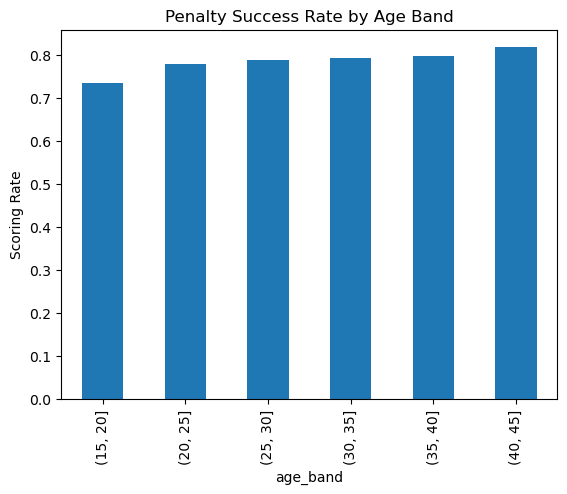

In [21]:
pen_player['age_band'] = pd.cut(pen_player['age_at_game'], bins=[15, 20, 25, 30, 35, 40, 45])
success_rates = pen_player.groupby('age_band')['scored'].mean()

success_rates.plot(kind='bar', ylabel='Scoring Rate', title='Penalty Success Rate by Age Band')

<Axes: title={'center': 'Penalty Success Rate by Age Band'}, xlabel='age_band', ylabel='Scoring Rate'>

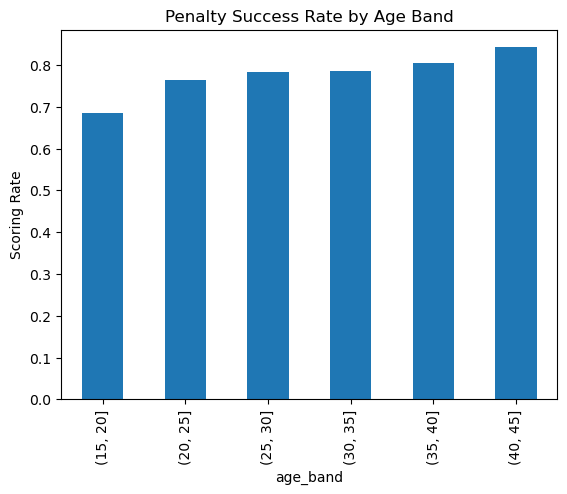

In [22]:
pen_comp['age_band'] = pd.cut(pen_comp['age_at_game'], bins=[15, 20, 25, 30, 35, 40, 45])
success_rates = pen_comp.groupby('age_band')['scored'].mean()

success_rates.plot(kind='bar', ylabel='Scoring Rate', title='Penalty Success Rate by Age Band')

## Exploring Fifa Penalty Rating on Penalty Success

In [23]:
#Standardizing penalty ratings to prepare for joining data
attr_pen = attr.sort_values('penalties', ascending=False).drop_duplicates('player_api_id')

In [24]:
pen_fifa = pd.merge(
    pen_player,
    attr_pen[['player_api_id', 'penalties']].rename(columns={'penalties': 'penalty_rating'}),
    on='player_api_id',
    how='left'
)

In [25]:
pen_fifa.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,matchday,OfficialMatchName,FinalResult,...,ScoreBefore,fcompMatchID,country,TournamentName,order,birth_year,age_at_game,scored,age_band,penalty_rating
0,2,155782,aaron cresswell,189615,1989-12-15 00:00:00,170.18,146,Fourth Round,West Ham United - Manchester City,5:3 on pens,...,3:2,1165,England,cups/cgb-efl-cup,7.0,1989,32,1,"(30, 35]",59.0
1,2,155782,aaron cresswell,189615,1989-12-15 00:00:00,170.18,146,Third Round Replay,West Ham United - Everton FC,11:10 on pens,...,3:3,2407,England,cups/fac-fa-cup,8.0,1989,25,1,"(20, 25]",59.0


In [26]:
#Running logistic regression to understand significance of FIFA penalty rating

X = pen_fifa[['penalty_rating']]
X = sm.add_constant(X)
y = pen_fifa['scored']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.517940
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 scored   No. Observations:                15981
Model:                          Logit   Df Residuals:                    15979
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:               0.0008841
Time:                        12:52:24   Log-Likelihood:                -8277.2
converged:                       True   LL-Null:                       -8284.5
Covariance Type:            nonrobust   LLR p-value:                 0.0001295
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9172      0.102      8.962      0.000       0.717       1.118
penalty_rating   

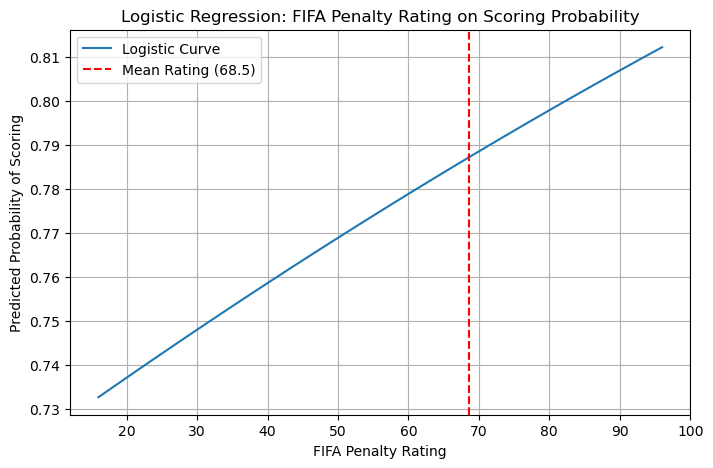

In [27]:
#Visualizing logistic regression results
import matplotlib.pyplot as plt
from math import exp

intercept = 0.9172
coef = 0.0057
ratings = np.linspace(pen_fifa['penalty_rating'].min(), pen_fifa['penalty_rating'].max(), 100)
log_odds = intercept + coef * ratings
probabilities = 1 / (1 + np.exp(-log_odds))
mean_rating = pen_fifa['penalty_rating'].mean()

plt.figure(figsize=(8, 5))
plt.plot(ratings, probabilities, label='Logistic Curve')
plt.axvline(mean_rating, color='red', linestyle='--', label=f'Mean Rating ({mean_rating:.1f})')
plt.xlabel("FIFA Penalty Rating")
plt.ylabel("Predicted Probability of Scoring")
plt.title("Logistic Regression: FIFA Penalty Rating on Scoring Probability")
plt.legend()
plt.grid(True)
plt.show()